## Data

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_images_from_file(paths, show_idxs = [], resize = 32):
    """
    Function retrieves images from local file paths, resizes the images, and flattens them into a 1-dimensional 
    array. The resized images can be displayed using the show_idxs attribute.
    
    Parameters
    ----------
    paths: lst
        List of paths of local files containing images to be read.
    show_idxs: lst
        List of index locations of the resized images to be displayed.
    resize: int
        The pixel dimensions used to resize all images.
        
    Returns
    -------
    X: lst
        List of numpy arrays of image attributes (integers on scale [0, 256] representing RGB colour intensities for 
        each pixel) taken from resized flattened images.
    y: lst
        List of labels from 0 to len(paths)-1. In the case of binary classification, this is a list of 0s and 1s
        corresponding to the locations of the flattened images in X.
    """
    
    X = []
    y = []
    
    # loops over the paths then filenames where data is located
    for i, path in enumerate(paths):
        for j, filename in enumerate(os.listdir(path)):
            
            # skip over filenames that are not images
            if filename == '.ipynb_checkpoints':
                continue
                
            # read and resize images
            img = cv2.imread(os.path.join(path, filename))
            if img is None:
                continue
            resized_img = cv2.resize(img, dsize = (resize, resize))
            
            # display a portion of loaded resized images
            if j in show_idxs:
                
                # change colour order of images from OpenCV (BGR) -> matplotlib (RBG)
                rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
                plt.matshow(rgb_img)
                plt.show()

            X.append(resized_img)
            y.append(i)

    return X, y

In [3]:
# load training data
path_train_not_sunsets = '/content/drive/MyDrive/CS156_Assignment/train/not_sunsets'
path_train_sunsets = '/content/drive/MyDrive/CS156_Assignment/train/sunsets'

X_train, y_train = get_images_from_file([path_train_not_sunsets, path_train_sunsets])

In [4]:
# load testing data
path_test_not_sunsets = '/content/drive/MyDrive/CS156_Assignment/test/not_sunsets'
path_test_sunsets = '/content/drive/MyDrive/CS156_Assignment/test/sunsets'

X_test, y_test = get_images_from_file([path_test_not_sunsets, path_test_sunsets])

## Aumentation: GAN

In [5]:
# extract only sunset images
x_train = np.array(X_train)[np.array(y_train) == 1]
x_test = np.array(X_test)[np.array(y_test) == 1]

# combine all sunset images
x_train_concatenated = np.concatenate((x_train, x_test), axis = 0)
x_train_floats = x_train_concatenated.astype(np.float32)

# normalise to be in range [-1, 1]
x_train_norm = (x_train_floats - 127.5) / 127.5

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Input, Flatten, Reshape
from keras.optimizers import Adam
from keras import initializers

latent_dim = 100

def build_generator():
    """
    Build a generator model for a Generative Adversarial Network (GAN).

    Returns
    --------
    Model(noise, img)
        A Keras `Model` object.
    """
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod((32, 32, 3)), activation='tanh'))
    model.add(Reshape((32, 32, 3)))

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator():
    """
    Build a discriminator model for a Generative Adversarial Network (GAN).

    Returns
    --------
    Model(img, validity)
        A Keras `Model` object.
    """
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=(32, 32, 3))
    validity = model(img)

    return Model(img, validity)

# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])

# build generator
generator = build_generator()
z = Input(shape=(latent_dim,))
img = generator(z)

discriminator.trainable = False
validity = discriminator(img)

# combine model
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [7]:
import tensorflow as tf
from scipy.linalg import sqrtm

def preprocess_images(images):
    """
    Preprocess images by resizing them and converting them to an acceptable format for 
    inception_v3.

    Parameters
    ----------
    images: lst
        List of images to be preprocessed.
    
    Returns
    -------
    images: lst
        The images that have been preprocessed.
    """
    images = tf.image.resize(images, (299, 299))
    images = tf.keras.applications.inception_v3.preprocess_input(images)
    return images

def calculate_fid(real_images, generated_images):
    """
    Calculates the Fréchet Inception Distance (FID) between two sets of images.
    The FID is a measure of the similarity between the distributions of features 
    extracted from the Inception V3 model for the real and generated images.

    Parameters
    ----------
    real_images: tensor
        A tensor of shape `(n_samples, height, width, channels)` representing the real images.
    generated_images: tensor
        A tensor of shape `(n_samples, height, width, channels)` representing the generated images.

    Returns
    -------
    fid: float
        The calculated FID score.
    """
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # extract the feature activations for the real and generated images
    real_activations = inception_model.predict(real_images, verbose = 0)
    generated_activations = inception_model.predict(generated_images, verbose = 0)

    # calculate the mean and covariance of the feature activations for the real and generated images
    mu1, sigma1 = real_activations.mean(axis=0), np.cov(real_activations, rowvar=False)
    mu2, sigma2 = generated_activations.mean(axis=0), np.cov(generated_activations, rowvar=False)

    ssd = np.sum((mu1 - mu2)**2)
    cov_mean = sqrtm(sigma1.dot(sigma2))
    
    # if the covariance is complex, take only the real part
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    fid = ssd + np.trace(sigma1 + sigma2 - 2 * cov_mean)
    return fid

In [8]:
def train(X_train, epochs, batch_size, progress_interval, save_interval):
    """
    Trains a generative adversarial network.

    Parameters
    ----------
    X_train : np.ndarray
        The training data, a numpy array of shape (num_samples, height, width, channels).
    epochs : int
        The number of epochs to train the model for.
    batch_size : int
        The batch size used during training.
    progress_interval : int
        The interval at which to print progress updates.
    save_interval : int
        The interval at which to calculate FID scores and save generated images.

    Returns
    -------
    d_losses : lst
        The discriminator loss at each epoch.
    d_accuracies : lst
        The discriminator accuracy at each epoch.
    g_losses : lst
        The generator loss at each epoch.
    fid_scores : lst
        The FID score at each epoch when `save_interval` is reached.
    """
    half_batch = int(batch_size / 2)
    d_losses = []
    d_accuracies = []
    g_losses = []
    fid_scores = []
    
    for epoch in range(epochs):
        # train discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        gen_imgs = generator.predict(noise, verbose = 0)

        # calculate disciminator loss
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.array([1] * batch_size)

        # calculate generator loss
        g_loss = combined.train_on_batch(noise, valid_y)

        # print progress
        if epoch % progress_interval == 0:
            print(f"Epoch {epoch}: [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            d_losses.append(d_loss[0])
            d_accuracies.append(d_loss[1])
            g_losses.append(g_loss)

        # calculate FID and Inception scores every 500 epochs
        if epoch % save_interval == 0:
            n_samples = 100
            noise = np.random.normal(0, 1, (n_samples, latent_dim))
            gen_imgs = generator.predict(noise, verbose = 0)
            gen_imgs = 0.5 * gen_imgs + 0.5

            fid_score = calculate_fid(X_train[:n_samples], gen_imgs)
            print(f"Epoch {epoch}: FID score: {fid_score}")
            fid_scores.append(fid_score)

            save_imgs(epoch)

    return d_losses, d_accuracies, g_losses, fid_scores


def save_imgs(epoch):
    """
    Saves generated images to disk.

    Parameters
    ----------
    epoch : int
        The current epoch number.
    """

    # generate 25 images
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise, verbose = 0)

    # rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    count = 0
    for i in range(r):
        for j in range(c):
            
            # convert colours from CV2 to matplotlib format
            axs[i, j].imshow(cv2.cvtColor(gen_imgs[count, :, :, :], cv2.COLOR_BGR2RGB))
            axs[i, j].axis('off')
            count += 1
    plt.savefig(f"sunsets_GAN_{epoch}.png")
    plt.close()

In [9]:
progress_interval = 100
save_interval = 500
d_losses, d_accuracies, g_losses, fid_scores = train(x_train_norm, epochs=15000, batch_size=32, progress_interval = progress_interval, save_interval=save_interval)

Epoch 0: [D loss: 0.6676372587680817, acc.: 37.5%] [G loss: 0.4661162495613098]
Epoch 0: FID score: 5.489790522869095
Epoch 100: [D loss: 0.058498816564679146, acc.: 100.0%] [G loss: 2.1385040283203125]
Epoch 200: [D loss: 0.14373846352100372, acc.: 96.875%] [G loss: 2.4226746559143066]
Epoch 300: [D loss: 0.5071708559989929, acc.: 81.25%] [G loss: 1.7539033889770508]
Epoch 400: [D loss: 0.6305739879608154, acc.: 62.5%] [G loss: 1.3189367055892944]
Epoch 500: [D loss: 0.7326676845550537, acc.: 59.375%] [G loss: 1.0231071710586548]
Epoch 500: FID score: 2.6370648715351264
Epoch 600: [D loss: 0.7064749002456665, acc.: 56.25%] [G loss: 0.9308619499206543]
Epoch 700: [D loss: 0.7064356505870819, acc.: 50.0%] [G loss: 0.761498212814331]
Epoch 800: [D loss: 0.6954697668552399, acc.: 59.375%] [G loss: 0.7882177829742432]
Epoch 900: [D loss: 0.7575664222240448, acc.: 34.375%] [G loss: 0.8098118305206299]
Epoch 1000: [D loss: 0.7704155147075653, acc.: 40.625%] [G loss: 0.8041191101074219]
Epoch

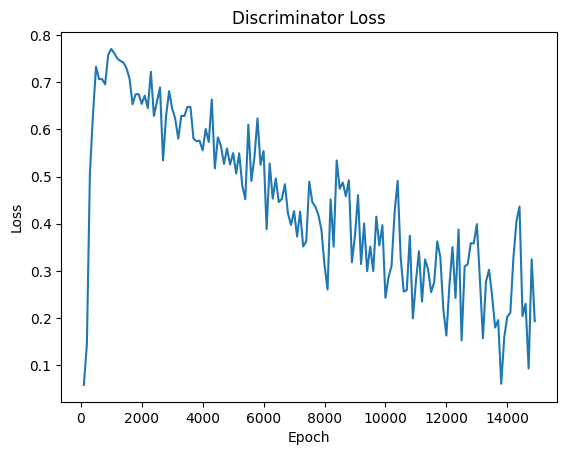

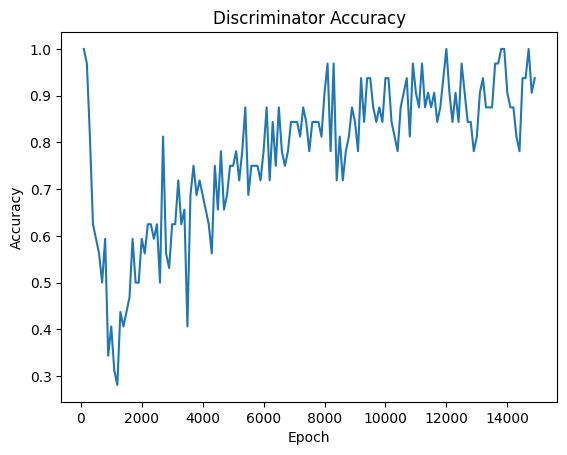

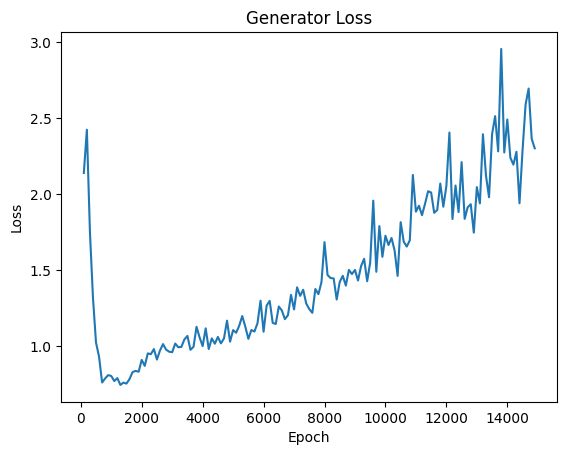

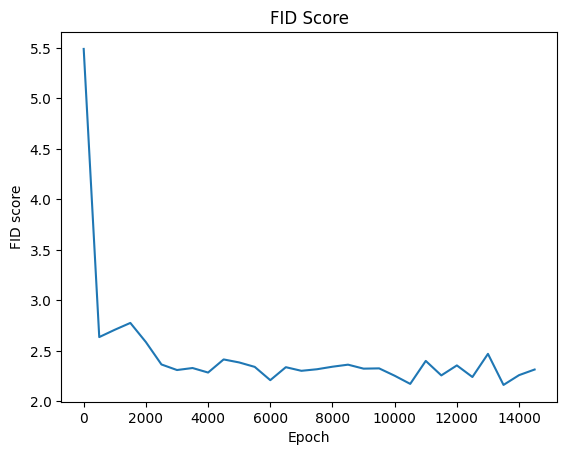

In [10]:
# plot resulting metrics
plt.plot(np.arange(progress_interval, len(d_losses)*progress_interval, progress_interval), d_losses[1:])
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(progress_interval, len(d_accuracies)*progress_interval, progress_interval), d_accuracies[1:])
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(np.arange(progress_interval, len(g_losses)*progress_interval, progress_interval), g_losses[1:])
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(np.arange(0, len(fid_scores)*save_interval, save_interval), fid_scores)
plt.title('FID Score')
plt.xlabel('Epoch')
plt.ylabel('FID score')
plt.show()

## Augmentation: VAE

In [11]:
# extract only sunset images
x_train = np.array(X_train)[np.array(y_train) == 1]
x_test = np.array(X_test)[np.array(y_test) == 1]

# normalize the images to be in the range [0, 1]
x_train, x_test = np.array(x_train) / 255.0, np.array(x_test) / 255.0

# flatten the images from (28, 28, 3) to (2352,)
x_train = np.array(x_train).reshape(-1, 32 * 32 * 3)
x_test = np.array(x_test).reshape(-1, 32 * 32 * 3)

In [12]:
import tensorflow.keras.metrics as metrics

class KLDivergenceMetric(metrics.Metric):
    """
    Computes the Kullback-Leibler divergence metric.

    Attributes
    ----------
    kl_divergence : tf.Variable
        The accumulated KL divergence.
    num_samples : tf.Variable
        The total number of samples.

    Methods
    -------
    update_state(y_true, y_pred, sample_weight=None)
        Accumulates KL divergence from a batch of data.
    result()
        Computes the final KL divergence.
    reset_state()
        Resets accumulated KL divergence and number of samples.
    """
    def __init__(self, name='kl_divergence', **kwargs):
        super(KLDivergenceMetric, self).__init__(name=name, **kwargs)
        self.kl_divergence = self.add_weight(name='kl_div', initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Accumulates KL divergence from a batch of data.

        Parameters
        ----------
        y_true : tf.Tensor
            The true values.
        y_pred : tf.Tensor
            The predicted values.
        sample_weight : tf.Tensor
            Sample weights.
        """
        z_mean, z_log_var = encoder(y_true)[:2]

        # calculate KL divergence/loss
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        num_samples_in_batch = K.cast(K.shape(y_true)[0], dtype='float32')
        self.kl_divergence.assign_add(K.sum(kl_loss))
        self.num_samples.assign_add(num_samples_in_batch)

    def result(self):
        """
        Computes the final KL divergence.

        Returns
        -------
        float
            The KL divergence.
        """
        return self.kl_divergence / self.num_samples

    def reset_state(self):
        """
        Resets accumulated KL divergence and number of samples.
        """
        self.kl_divergence.assign(0.0)
        self.num_samples.assign(0.0)

In [13]:
class VisualizeExamples(tf.keras.callbacks.Callback):
    """
    Callback that generates and saves images of examples to visualise.

    Attributes
    ----------
    decoder : tf.keras.Model
        The decoder model used to generate images.
    examples_to_visualize : tf.Tensor
        A tensor containing examples to visualize.

    Methods
    -------
    on_epoch_end(epoch, logs=None)
        Generates and saves images of examples to visualise at the end of each epoch.
    """
    def __init__(self, decoder, examples_to_visualize):
        super(VisualizeExamples, self).__init__()
        self.decoder = decoder
        self.examples_to_visualize = examples_to_visualize

    def on_epoch_end(self, epoch, logs=None):
        """
        Generates and saves images of examples to visualise at the end of each epoch.

        Parameters
        ----------
        epoch : int
            The current epoch number.
        logs : dict
            The dictionary of logs.
        """

        if (epoch+1)%500 == 0:
            # generate images from the examples
            generated_images = self.decoder.predict(self.examples_to_visualize)

            # save the generated images
            n = len(self.examples_to_visualize)
            plt.figure(figsize=(2 * n, 2))
            for i in range(n):
                ax = plt.subplot(1, n, i + 1)

                # convert colours from cv to matplotlib to visualise
                plt.imshow(cv2.cvtColor(generated_images[i].reshape(32, 32, 3), cv2.COLOR_BGR2RGB))
                plt.axis('off')
            plt.savefig(f'sunsets_{epoch+1}.png')
            plt.close()

In [14]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

# define VAE architecture
latent_dim = 2

def sampling(args):
    """
    Uses the reparameterisation trick to sample from the latent space.

    Parameters
    ----------
    args : tuple of tensors
        The mean and log variance of the latent distribution.

    Returns
    -------
    tensor
        The sampled tensor from the latent space.
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# encoder
inputs = Input(shape=(32 * 32 * 3,))
h_enc = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
z_mean = Dense(latent_dim)(h_enc)
z_log_var = Dense(latent_dim)(h_enc)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z])

# decoder
latent_inputs = Input(shape=(latent_dim,))
h_dec = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(latent_inputs)
outputs = Dense(3072, activation='sigmoid')(h_dec)
decoder = Model(latent_inputs, outputs)

# VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

# VAE loss (binary cross entropy)
reconstruction_loss = binary_crossentropy(inputs, outputs) * 3072
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam', metrics=[KLDivergenceMetric()])

# set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# choose some random examples from the latent space
examples_to_visualize = np.random.normal(size=(10, latent_dim))

# create a callback instance with the chosen examples
visualize_examples_callback = VisualizeExamples(decoder, examples_to_visualize)

# train the VAE with the custom callback
history = vae.fit(x_train, x_train,
        epochs=1000,
        batch_size=100,
        validation_data=(x_test, x_test),
        callbacks=[visualize_examples_callback])

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 2134.9690 - kl_divergence: 37.5881 - val_loss: 2153.9897 - val_kl_divergence: 37.2105
Epoch 2/1000
1/1 [==============================] - 0s 181ms/step - loss: 2158.8354 - kl_divergence: 5.1541 - val_loss: 2118.5283 - val_kl_divergence: 5.1099
Epoch 3/1000
1/1 [==============================] - 0s 192ms/step - loss: 2120.3342 - kl_divergence: 6.4534 - val_loss: 2105.9924 - val_kl_divergence: 6.4015
Epoch 4/1000
1/1 [==============================] - 0s 188ms/step - loss: 2108.6179 - kl_divergence: 19.6582 - val_loss: 2083.4490 - val_kl_divergence: 19.5569
Epoch 5/1000
1/1 [==============================] - 0s 183ms/step - loss: 2091.2307 - kl_divergence: 35.1961 - val_loss: 2061.4536 - val_kl_divergence: 35.2313
Epoch 6/1000
1/1 [==============================] - 0s 113ms/step - loss: 2076.4866 - kl_divergence: 40.0179 - val_loss: 2038.7925 - val_kl_divergence: 40.4061
Epoch 7/1000
1/1 [=============================

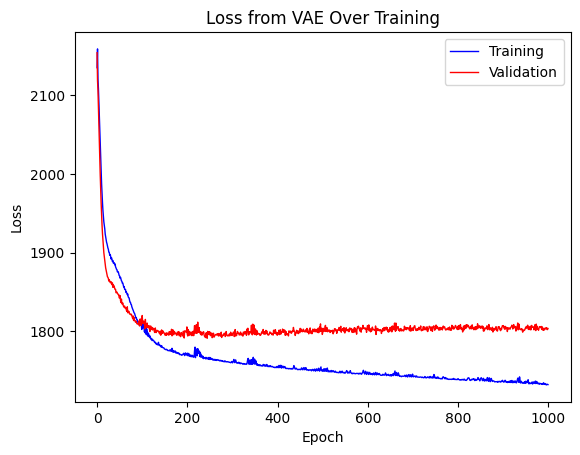

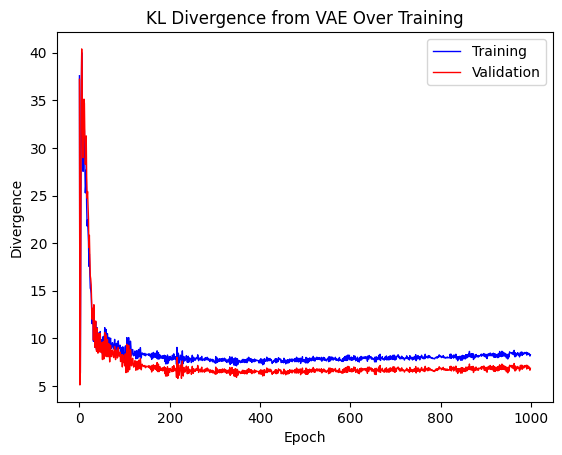

In [15]:
# plot metrics over training
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
kl_divergence = history.history['kl_divergence']
val_kl_divergence = history.history['val_kl_divergence']

plt.plot(range(len(training_loss)), training_loss, color = 'blue', label = 'Training', linewidth = 1)
plt.plot(range(len(validation_loss)), validation_loss, color = 'red', label = 'Validation', linewidth = 1)
plt.title('Loss from VAE Over Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(len(kl_divergence)), kl_divergence, color = 'blue', label = 'Training', linewidth = 1)
plt.plot(range(len(val_kl_divergence)), val_kl_divergence, color = 'red', label = 'Validation', linewidth = 1)
plt.title('KL Divergence from VAE Over Training')
plt.xlabel('Epoch')
plt.ylabel('Divergence')
plt.legend()
plt.show()

In [16]:
# generate new images
num_images = 150
latent_vectors = np.random.normal(size=(num_images, latent_dim))

# feed latent vectors into decoder
generated_images = decoder.predict(latent_vectors)
generated_images = generated_images.reshape((-1, 32, 32, 3))

# append the new images to the training set
augmented_X_train = np.concatenate((X_train, generated_images))
augmented_y_train = np.concatenate((y_train, [1]*num_images))

5/5 [==============================] - 0s 5ms/step


## MobileNetV2

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras import metrics
from sklearn.model_selection import KFold
from tensorflow.keras import regularizers

def resize_images(images, size):
    """
    Resizes a batch of images to a specified size.

    Parameters
    ----------
    images : array
        The batch of images to resize.
    size : int
        The size to resize the images to.

    Returns
    -------
    array
        The resized batch of images.
    """
    return np.array([cv2.resize(img, (size, size)) for img in images])

def mobilenet_cv(X_train, y_train, k = 5, lr = 0.0001):
    """
    Perform K-Fold Cross-Validation on a MobileNetV2 model.

    Parameters
    ----------
    X_train : lst
        The training input data.
    y_train : lst
        The target training data.
    k : int, optional
        The number of folds to use for cross-validation. Defaults to 5.
    lr : float, optional
        The learning rate of the new model layers. Defaults to 0.0001.

    Returns
    -------
    tuple of list of floats
        A tuple of metric scores for each fold of the cross-validation.
        The first element is a list of accuracy scores.
        The second element is a list of validation accuracy scores.
        The third element is a list of loss scores.
        The fourth element is a list of validation loss scores.
        The fifth element is a list of precision scores.
        The sixth element is a list of validation precision scores.
        The seventh element is a list of AUC scores.
        The eighth element is a list of validation AUC scores.
    """
    tf.random.set_seed(42)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # reshape the entire dataset first
    X_train_reshaped = resize_images(X_train, 224)

    acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc = [], [], [], [], [], [], [], []

    for fold, (train_indices, val_indices) in enumerate(kf.split(X_train)):

        # split data into train and validation sets
        x_train_fold = X_train_reshaped[train_indices]
        y_train_fold = np.array(y_train)[train_indices]
        x_val_fold = X_train_reshaped[val_indices]
        y_val_fold = np.array(y_train)[val_indices]

        # create a new model with added layers
        base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
        x = Dropout(0.5)(x)

        # added dimensionality reduction
        predictions = Dense(1)(x)
        model = Model(inputs=base_model.input, outputs=predictions)

        # freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False

        # compile the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                    metrics=[metrics.BinaryAccuracy(name='accuracy'),
                        metrics.Precision(name='precision'),
                        metrics.AUC(name='auc')])

        # train the model on the current fold
        history = model.fit(x_train_fold, y_train_fold, epochs=10, batch_size=32, 
                            validation_data=(x_val_fold, y_val_fold), verbose = 0)

        # record metric scores
        acc.append(history.history['accuracy'])
        val_acc.append(history.history['val_accuracy'])
        loss.append(history.history['loss'])
        val_loss.append(history.history['val_loss'])
        prec.append(history.history['precision'])
        val_prec.append(history.history['val_precision'])
        auc.append(history.history['auc'])
        val_auc.append(history.history['val_auc'])

    return model, acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc

In [18]:
def plot_mobilenet_cv(acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc):
    """
    Plot training and validation metrics for a MobileNet model trained with cross-validation.
    This function creates a 1x4 grid of subplots, where each subplot corresponds to one of the metrics
    (accuracy, loss, precision, and AUC). For each metric, the function plots the mean score across
    the K cross-validation folds for both training and validation, along with the 95% confidence
    interval obtained by computing the 2.5th and 97.5th percentiles of the scores across folds at each epoch.
    The x-axis of the plot corresponds to the number of training epochs (T), while the y-axis corresponds
    to the value of the metric.

    Parameters
    ----------
    acc : lst
        Training accuracy scores for K cross-validation folds and T epochs.
    val_acc : lst
        Validation accuracy scores for K cross-validation folds and T epochs.
    loss : lst
        Training loss values for K cross-validation folds and T epochs.
    val_loss : lst
        Validation loss values for K cross-validation folds and T epochs.
    prec : lst
        Training precision scores for K cross-validation folds and T epochs.
    val_prec : lst
        Validation precision scores for K cross-validation folds and T epochs.
    auc : lst
        Training AUC scores for K cross-validation folds and T epochs.
    val_auc : lst
        Validation AUC scores for K cross-validation folds and T epochs.

    Returns
    -------
    None
    """
    fig, ax = plt.subplots(1, 4, figsize = (15, 5))

    labels = ['Accuracy', 'Loss', 'Precision', 'AUC']
    for i, metric in enumerate([[acc, val_acc], [loss, val_loss], [prec, val_prec], [auc, val_auc]]):
        ax[i].plot(np.mean(metric[0], axis = 0), label='Training')
        ax[i].fill_between(range(10), np.percentile(metric[0], 2.5, axis = 0), np.percentile(metric[0], 97.5, axis = 0), alpha = 0.3)
        ax[i].plot(np.mean(metric[1], axis = 0), label='Validation')
        ax[i].fill_between(range(10), np.percentile(metric[1], 2.5, axis = 0), np.percentile(metric[1], 97.5, axis = 0), alpha = 0.3)
        if i == 3:
            ax[i].legend()
        ax[i].set_title(labels[i])

    fig.suptitle('Training and Validation Metrics Across Training Epochs')
    fig.supxlabel('Epoch')
    fig.tight_layout()
    plt.show()

In [19]:
cnn_model, acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc = mobilenet_cv(augmented_X_train, augmented_y_train)

In [20]:
print('Precision Validation Score:', round(np.mean(val_prec, axis = 0)[-1], 3))
print('Accuracy Validation Score:', round(np.mean(val_auc, axis = 0)[-1], 3))
print('AUC Validation Score:', round(np.mean(val_acc, axis = 0)[-1], 3))

Precision Validation Score: 0.942
Accuracy Validation Score: 0.875
AUC Validation Score: 0.88


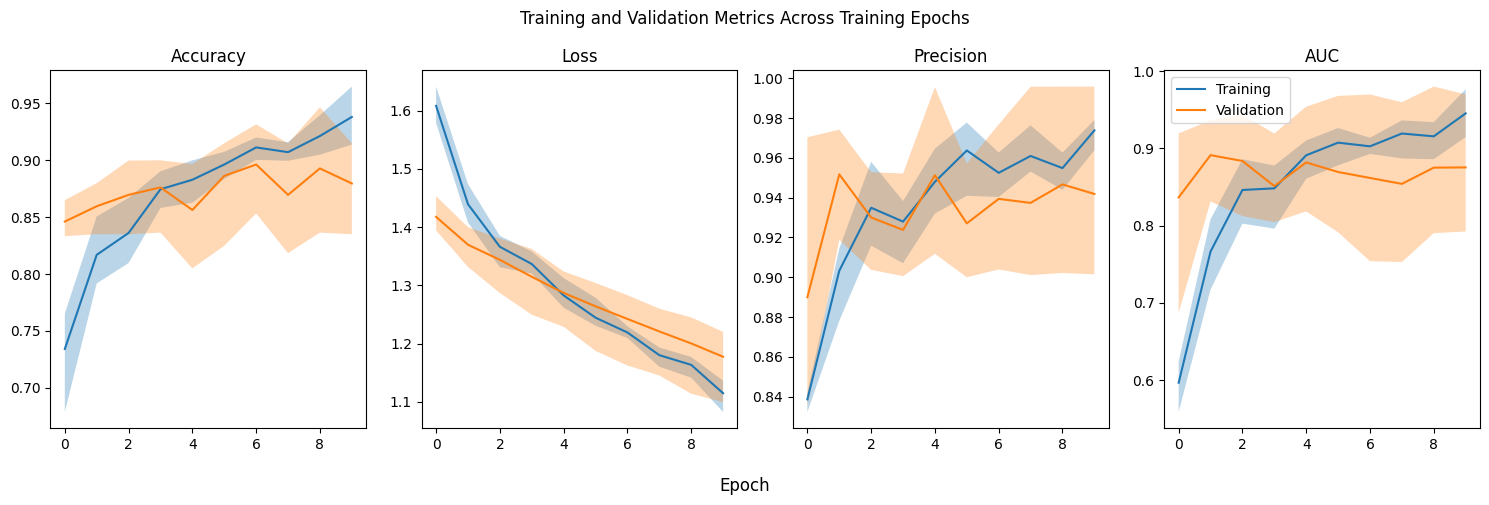

In [21]:
plot_mobilenet_cv(acc, val_acc, loss, val_loss, prec, val_prec, auc, val_auc)

## Traditional ML Models: Logistic Regression, SVC, KNN & Decision Trees

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

def logreg_svc_knn_CV(X_train, y_train):
    """
    Completes grid search cross validation on logistic regression, KNN, SVC and decision tree models with varying hyperparameters.
    For each of 5 folds, the model is fit on 4/5, the other being reserved for measuring precision. GridSearchCV 
    does this for all classifier/parameter combinations and returns an object containing the results for each 
    combination, including precisions for each fold of the CV.

    Parameters
    ----------
    X_train: lst
        Nested list of predictors for each observation. In the case of sunset classification, this is a list of image 
        attributes (integers on scale [0, 256] representing RGB colour intensities for each pixel).
    y_train: lst
        List of labels, the targets of the classification (0: not sunset, 1: sunset).
        
    Returns
    -------
    gs: GridSearchCV obj
        An object containing the results for each combination, including precisions for each fold of the CV.
    """
    
    # number of folds for CV
    kfold = KFold(n_splits = 5, random_state = 123, shuffle = True)
    
    clf_logreg = LogisticRegression(random_state = 123, max_iter = 1000)
    clf_svc = SVC(random_state = 123)
    clf_knn = KNeighborsClassifier()
    clf_dt = DecisionTreeClassifier(random_state=123)

    # hyperparameters to optimise over for logistic regression
    param_logreg = {
        'classifier': [clf_logreg],
        'classifier__C': np.power(10.0, np.arange(-4, 5)),
        'classifier__solver': ['liblinear', 'lbfgs', 'sag', 'saga']
    }

    # hyperparameters to optimise over for SVC
    param_svc = {
        'classifier': [clf_svc],
        'classifier__C': np.power(10.0, np.arange(-4, 5)),
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }

    # hyperparameters to optimise over for KNN
    param_knn = {
        'classifier': [clf_knn],
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    }

    # hyperparameters to optimise over for decision tree
    param_dt = {
        'classifier': [clf_dt],
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10, 20],
    }
    
    pipeline = Pipeline([('classifier', clf_logreg)])
    param_grid = [param_logreg, param_svc, param_knn, param_dt]

    # fit for different parameters & models, for each of k folds
    gs = GridSearchCV(pipeline, param_grid = param_grid, scoring = 'precision', cv = kfold, n_jobs = -1, verbose = 3)
    gs.fit(X_train, y_train)
    
    print('Best parameters:', gs.best_params_)
    
    return gs

In [23]:
num_images = augmented_X_train.shape[0]
augmented_X_train_reshaped = augmented_X_train.reshape(num_images, -1)
gs = logreg_svc_knn_CV(augmented_X_train_reshaped, augmented_y_train)

Fitting 5 folds for each of 104 candidates, totalling 520 fits
Best parameters: {'classifier': SVC(C=10.0, random_state=123), 'classifier__C': 10.0, 'classifier__kernel': 'rbf'}


In [24]:
import seaborn as sns

def plot_gs_results(df_gs, params1, params2, params3, params4, model1, model2, model3, model4, title):
    """
    Plots the results of precision scores from gridsearch dataframe. The function creates four subplots, one containing
    the results for the first model based on two chosen parameters, the second containing the results of the second model
    based on two chosen parameters, the third containing the results of the third model based on two chosen parameters
    and the fourth containing the results of the fourth model based on two chosen parameters
    (can be the same of different features).
    
    Parameters
    ----------
    df_gs: df
        Dataframe containing the results from a GridSearchCV object.
    params1: lst
        List of parameters to plot on subplot one. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    params2: lst
        List of parameters to plot on subplot two. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    params3: lst
        List of parameters to plot on subplot three. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    params4: lst
        List of parameters to plot on subplot four. The first element of the list is the x axis, the second the y axis, and
        the third the hue.
    model1: str
        The name of the classifier used for subplot one.
    model2: str
        The name of the classifier used for subplot two.
    model3: str
        The name of the classifier used for subplot three.
    model4: str
        The name of the classifier used for subplot four.
    title: str
        Extension of the title specifying which input data.
    
    Returns
    -------
    None
    """
    
    # initialise plots and plot params for each model
    fig, ax = plt.subplots(2, 2, sharey=True, figsize=(10, 10))
    sns.scatterplot(data=df_gs, x=params1[0], y=params1[1], hue=params1[2], ax=ax[0][0])
    sns.scatterplot(data=df_gs, x=params2[0], y=params2[1], hue=params2[2], ax=ax[0][1])
    sns.scatterplot(data=df_gs, x=params3[0], y=params3[1], hue=params3[2], ax=ax[1][0])
    sns.scatterplot(data=df_gs, x=params4[0], y=params4[1], hue=params4[2], ax=ax[1][1])
    
    # rescale axis to display C at regular intervals
    ax[0][0].set_xscale('log')
    ax[0][1].set_xscale('log')
    ax[0][0].set_title(model1)
    ax[0][1].set_title(model2)
    ax[1][0].set_title(model3)
    ax[1][1].set_title(model4)
    ax[1][0].set_xticks([3, 5, 7, 9])
    ax[1][1].set_xticks([2, 5, 10, 20])
    fig.suptitle('Precision Scores for Different Models and Parameters with '+title)
    fig.tight_layout()
    plt.show()

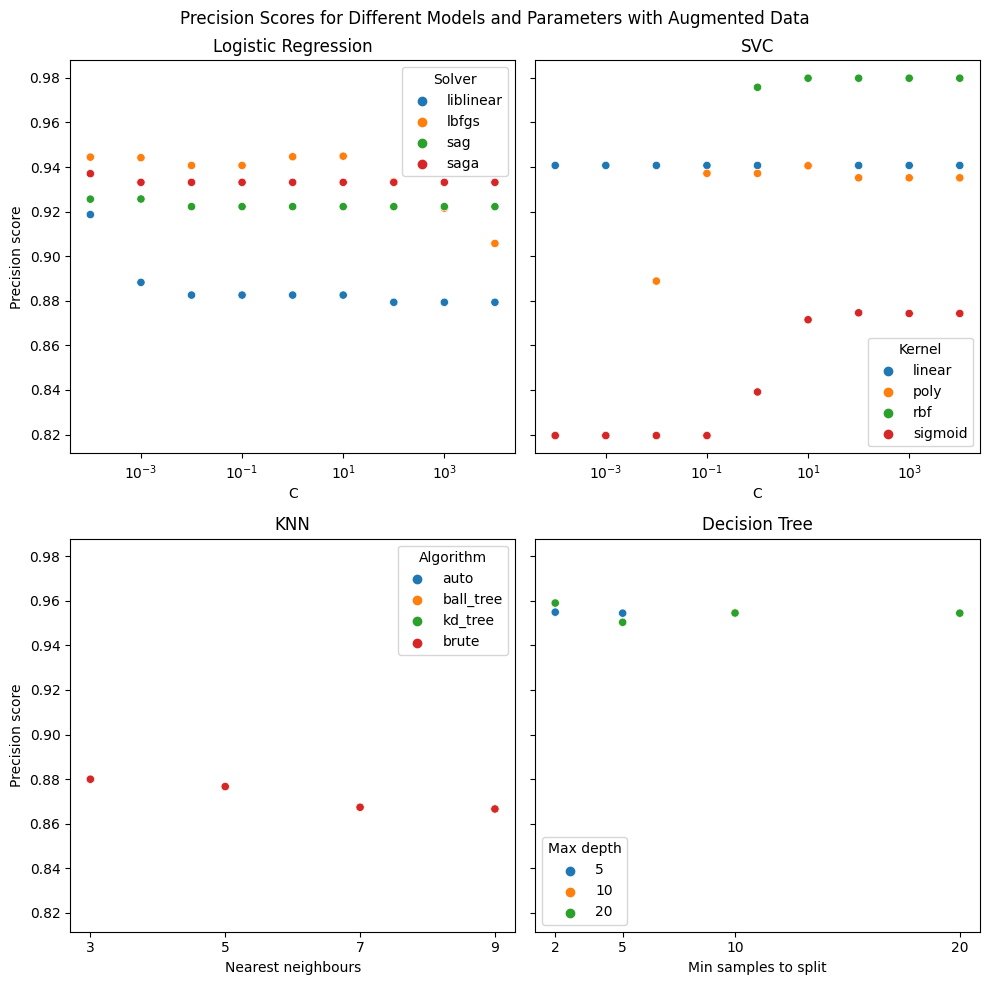

In [25]:
import pandas as pd

# convert grid search results to df, and rename columns for plotting
df_gs = pd.DataFrame(gs.cv_results_)
df_gs.rename(columns={'param_classifier__C':'C', 'mean_test_score':'Precision score', 
                      'param_classifier__solver':'Solver', 
                      'param_classifier': 'Model', 'param_classifier__kernel':'Kernel',
                      'param_classifier__n_neighbors': 'Nearest neighbours', 'param_classifier__algorithm': 'Algorithm',
                      'param_classifier__max_depth': 'Max depth', 'param_classifier__min_samples_split': 'Min samples to split'}, inplace=True)

plot_gs_results(df_gs, ['C', 'Precision score', 'Solver'], ['C', 'Precision score', 'Kernel'], 
                ['Nearest neighbours', 'Precision score', 'Algorithm'], ['Min samples to split', 'Precision score', 'Max depth'],
                'Logistic Regression', 'SVC', 'KNN', 'Decision Tree', 'Augmented Data')

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score

def confusion_metrics(y_pred, title):
    """
    Computes precision, auc, and accuracy scores for the input model's predictions, 
    and plots a confusion matrix between the test set classifications and predictions.

    Parameters
    ----------
    y_pred : arr
        Predicted target values.
    title : str
        The title end of the plot.

    Returns
    -------
    None
    """
    # precision, auc, and accuracy scores for model
    print('\033[1mScores for '+title+'\033[0m')
    print('Precision score for test set:', round(precision_score(y_test, y_pred), 3))
    print('AUC score for test set:', round(roc_auc_score(y_test, y_pred), 3))
    print('Accuracy score for test set:', round(accuracy_score(y_test, y_pred), 3))

    # plot confusion matrix between test set classifications and predictions
    cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels = ['Not', 'Sunset'])
    cmd.plot()
    plt.title('Confusion Matrix for Test Set with \n'+title)
    plt.show()

Scores for Augmented Data
Precision score for test set: 0.869
AUC score for test set: 0.923
Accuracy score for test set: 0.92


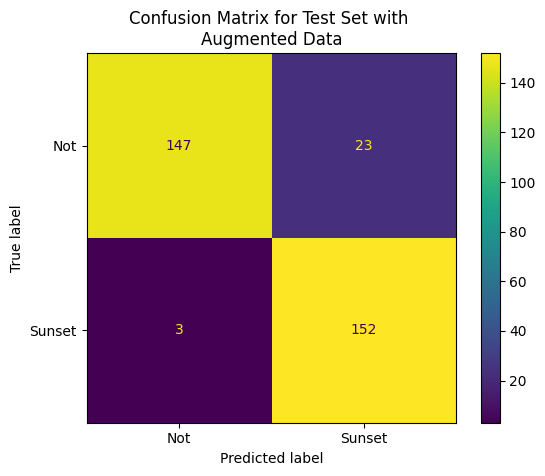

In [27]:
# make predictions from optimal grid search model
num_images = np.array(X_test).shape[0]
X_test_reshaped = np.array(X_test).reshape(num_images, -1)
y_pred = gs.predict(X_test_reshaped)
confusion_metrics(y_pred, 'Augmented Data')

In [28]:
def plot_incorrect_classifications(x_test, y_test, y_pred):
    """
    Plots incorrect classifications made by a model.

    Parameters
    ----------
    x_test : array
        The test set images.
    y_test : array
        The true labels of the test set.
    y_pred : array
        The predicted labels of the test set.
    """
    fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(15, 10))  
    count = 0
    for i in range(len(y_test)):

        # only plot up to the number of subplots available in axes
        if y_test[i] != y_pred[i] and count < axes.size:
            row = count // 7
            col = count % 7

            # convert colours from cv to matplotlib
            axes[row, col].imshow(cv2.cvtColor(x_test[i], cv2.COLOR_BGR2RGB))

            # print true and predicted labels for comparison
            axes[row, col].set_title(f"True: {y_test[i]}, Predicted: {y_pred[i]}")
            axes[row, col].axis('off')
            count += 1
    fig.subplots_adjust(wspace=0.05, hspace=0.005)
    plt.show()

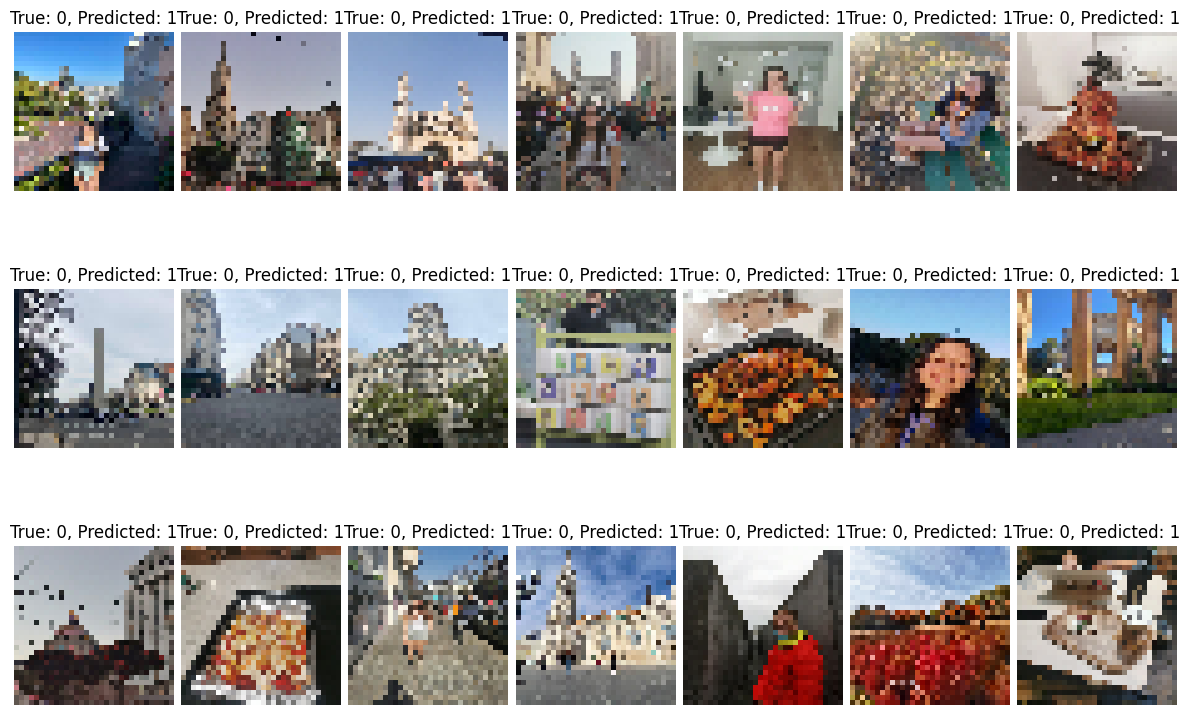

In [29]:
plot_incorrect_classifications(np.array(X_test), y_test, y_pred)